In [1]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from collections import Counter
from model import VTN
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import torch.nn.functional as F
import os
from utils import * 
import re
from vis_utils import * 


/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using concept features


In [2]:
def pad_to_window_size_local(input_ids: torch.Tensor, attention_mask: torch.Tensor, position_ids: torch.Tensor,
                             one_sided_window_size: int, pad_token_id: int):
    '''A helper function to pad tokens and mask to work with the sliding_chunks implementation of Longformer self-attention.
    Based on _pad_to_window_size from https://github.com/huggingface/transformers:
    https://github.com/huggingface/transformers/blob/71bdc076dd4ba2f3264283d4bc8617755206dccd/src/transformers/models/longformer/modeling_longformer.py#L1516
    Input:
        input_ids = torch.Tensor(bsz x seqlen): ids of wordpieces
        attention_mask = torch.Tensor(bsz x seqlen): attention mask
        one_sided_window_size = int: window size on one side of each token
        pad_token_id = int: tokenizer.pad_token_id
    Returns
        (input_ids, attention_mask) padded to length divisible by 2 * one_sided_window_size
    '''
    w = 2 * one_sided_window_size
    seqlen = input_ids.size(1)
    padding_len = (w - seqlen % w) % w
    input_ids = F.pad(input_ids.permute(0, 2, 1), (0, padding_len), value=pad_token_id).permute(0, 2, 1)
    attention_mask = F.pad(attention_mask, (0, padding_len), value=False)  # no attention on the padding tokens
    position_ids = F.pad(position_ids, (1, padding_len), value=False)  # no attention on the padding tokens
    return input_ids, attention_mask, position_ids

In [3]:
model = model.eval()
for j, batch in enumerate(dataloader_comma):
    _, image_array, vego, distance, angle, _, _, _, _, _ = batch   

    #mask = (distance.squeeze() > 100)
    #if mask.sum() < 20: continue
    #image_array = image_array[:, mask, :, :, :]
    #image_array = image_array[:, 0:20, :, :, :]
    #vego = vego[:, 0:20]
    #angle = angle[:, 0:20]
    #distance = distance[:, 0:20]
    img = image_array
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    x = img
    print(distance)
    (logits, _) = model(img, angle, distance, vego)
    break
    '''
    img = image_array
    logits =  logits.detach().cpu().to("cpu")
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    logits_per_image, logits_per_text = model.clip_model(img.reshape((img.shape[0]*img.shape[1], img.shape[2], img.shape[3], img.shape[4])), scenarios_tokens.to(img.device))
    

    concepts = logits_per_image
    top5_indices = torch.tensor(logits_per_image.softmax(dim=-1).squeeze()).topk(5).indices
    cs = []
    for elem in top5_indices[0]:
            cs.append(scenarios[elem])
    concept_to_change = [50, 239, 131, 119]
    for elem in concept_to_change:
        for i in range(concepts.shape[0]):
            concepts[i, elem] = 0
    top5_indices_new = torch.tensor(concepts.softmax(dim=-1).squeeze()).topk(5).indices

    concepts = concepts.detach().reshape((int(img.shape[0]), int(logits_per_image.shape[0]/img.shape[0]), -1))
    print(top5_indices, top5_indices_new)

    angle = torch.roll(angle, shifts=1, dims=1)
    angle[:,0] = angle[:,1]
    distance = torch.roll(distance, shifts=1, dims=1)
    distance[:,0] = distance[:,1]
    vego = torch.roll(vego, shifts=1, dims=1)
    vego[:,0] = vego[:,1]
    print(distance)

    # spatial backbone
    B, seq_len, C, H, W = x.shape

    x = concepts
    x = torch.cat((x, angle.unsqueeze(-1)), dim=-1)
    x = torch.cat((x, distance.unsqueeze(-1)), dim=-1)
    x = torch.cat((x, vego.unsqueeze(-1)), dim=-1)

    # temporal encoder (Longformer)
    B, D, E = x.shape
    attention_mask = torch.ones((B, D), dtype=torch.long, device=x.device)
    cls_tokens = model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    x = torch.cat((cls_tokens, x), dim=1)

    cls_atten = torch.ones(1).expand(B, -1).to(x.device)
    attention_mask = torch.cat((attention_mask, cls_atten), dim=1)
    attention_mask[:, 0] = 2 # initialize the start with a special number

    
    x, attention_mask, _ = pad_to_window_size_local(
        x,
        attention_mask,
        x,#position_ids, in case we wanted them
        model.temporal_encoder.config.attention_window[0],
        model.temporal_encoder.config.pad_token_id)

    token_type_ids = torch.zeros(x.size()[:-1], dtype=torch.long, device=x.device)
    token_type_ids[:, 0] = 1

    tmp = model.temporal_encoder(input_ids=None,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=None,#position_ids,
                                inputs_embeds=x,
                                output_attentions=True,
                                output_hidden_states=None,
                                return_dict=True)
    lhs = tmp["last_hidden_state"]
    lhs = model.mlp_head(lhs)
    res = lhs[:,1:seq_len+1,:]
    img, angle, distance, vego = img.to('cpu'), angle.to('cpu'), distance.to('cpu'), vego.to('cpu')'''

    break

tensor([[ 24.3125,  24.4375,  24.3750,  24.3750,  24.3125,  24.3750,  24.3125,
          24.2500,  24.2500,  24.1875,  24.1250,  24.0625,  24.0000,  24.0000,
          23.8125,  23.8125,  23.8125,  24.6250,  24.0625,  23.7500,  23.7500,
          23.7500,  23.8125,  23.8750,  23.9375,  24.0000,  24.1250,  24.0000,
          23.9375,  23.8125,  23.7500,  23.6250,  23.7500,  23.6250,  23.3125,
          23.3125,  23.1875,  23.2500,  23.0000,  22.8750,  22.7500,  23.4375,
          22.6875,  22.6875,  22.3750,  22.4375,  22.1875,  22.1250,  22.1250,
          22.1250,  22.2500,  22.8750,  22.7500,  22.6875,  21.6875,  21.8125,
          21.8125,  21.8125,  21.9375,  21.8125,  22.0625,  22.0000,  22.0000,
          22.3125,  21.9688,  22.0312,  22.0938,  22.0000,  22.0625,  22.0000,
          22.1250,  22.0000,  21.9375,  21.9375,  21.8750,  22.0000,  21.8125,
          21.7500,  21.6875,  21.6250,  21.3125,  21.3750,  21.7500,  21.8125,
          21.0625,  20.8750,  20.7500,  20.5000,  20

In [4]:
logits, distance

(tensor([[[4.4918],
          [4.5113],
          [4.4337],
          [4.2525],
          [4.2175],
          [4.4425],
          [4.2314],
          [4.2560],
          [4.2627],
          [4.1863],
          [4.2376],
          [4.1229],
          [4.1645],
          [4.2989],
          [4.2274],
          [4.3288],
          [4.3566],
          [4.3084],
          [4.1318],
          [4.2828],
          [4.3235],
          [4.0199],
          [4.0122],
          [3.8292],
          [3.8410],
          [3.9971],
          [4.1404],
          [4.2539],
          [4.5149],
          [4.9123],
          [4.9244],
          [4.7997],
          [4.9095],
          [4.8512],
          [4.9076],
          [4.7979],
          [4.8314],
          [4.7672],
          [4.6800],
          [4.4667],
          [4.3523],
          [4.3848],
          [4.0567],
          [4.1714],
          [4.4497],
          [4.3206],
          [4.3542],
          [4.7530],
          [4.6014],
          [4.6172],


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


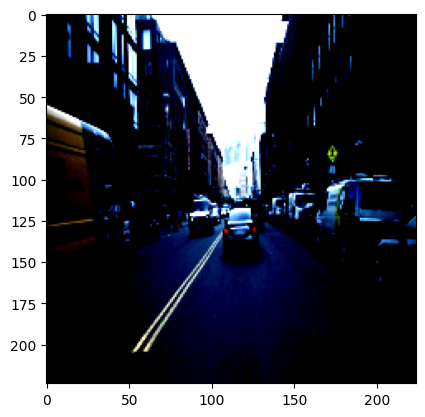

In [10]:
plt.imshow((img.squeeze()[18]).permute(1,2,0).cpu())